In [ ]:


!pip install dask-ms[xarray]



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 6.6 MB/s eta 0:00:00


In [ ]:
import dask.array as da
from daskms import xds_from_table, xds_from_ms
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Data path
data_path = '/content/drive/MyDrive/'
ms_path = data_path + "1548939342.ms"

# Load the measurement set
ds = xds_from_ms(ms_path)

description_table = xds_from_table(ms_path + "::DATA_DESCRIPTION")
print("Description Table Keys:")
for key in description_table[0].keys():
    print(f'{key}: {description_table[0][key].values}')

obs_table = xds_from_table(ms_path + "::OBSERVATION")
print("Observation Table Keys:")
for key in obs_table[0].keys():
    print(f'{key}: {obs_table[0][key].values}')

Mounted at /content/drive
Description Table Keys:
POLARIZATION_ID: [0]
SPECTRAL_WINDOW_ID: [0]
FLAG_ROW: [False]
Observation Table Keys:
RELEASE_DATE: [5.05565639e+09]
TELESCOPE_NAME: ['MeerKAT']
SCHEDULE: [['unavailable']]
LOG: [['unavailable']]
PROJECT: ['20190131-0012']
FLAG_ROW: [False]
TIME_RANGE: [[5.05565617e+09 5.05565639e+09]]
SCHEDULE_TYPE: ['unknown']
OBSERVER: ['Lindsay']


Extract Start and End Time

In [ ]:
# Extract the observation table
obs_table = xds_from_table(ms_path + "::OBSERVATION")
print("Observation Table Keys:")
for key in obs_table[0].keys():
    print(f'{key}: {obs_table[0][key].values}')

# Extract observation start and end time
start_time = obs_table[0]["TIME_RANGE"].values[0][0]
end_time = obs_table[0]["TIME_RANGE"].values[0][1]
start_time_days = start_time / (24 * 3600) #seconds -> mjd -> convert back to UTC or SAST
end_time_days = end_time / (24 * 3600)

start_time = Time(start_time_days, format='mjd').to_datetime()
end_time = Time(end_time_days, format='mjd').to_datetime()
print(f"Start Date: {start_time}")
print(f"End Date: {end_time}")

Observation Table Keys:
RELEASE_DATE: [5.05565639e+09]
TELESCOPE_NAME: ['MeerKAT']
SCHEDULE: [['unavailable']]
LOG: [['unavailable']]
PROJECT: ['20190131-0012']
FLAG_ROW: [False]
TIME_RANGE: [[5.05565617e+09 5.05565639e+09]]
SCHEDULE_TYPE: ['unknown']
OBSERVER: ['Lindsay']
Start Date: 2019-01-31 12:56:12.122526
End Date: 2019-01-31 12:59:48.031192


Extract Antenna Info

In [ ]:
# Extract antenna info
A1 = ds[0]["ANTENNA1"]
A2 = ds[0]["ANTENNA2"]
ant_list = list(set(np.append(A1, A2)))
nants = len(ant_list)
inter = ds[0]["INTERVAL"]

print(f'Total number of antennas used: {nants}')
print('Interval Table Shape: ', inter.shape)
print(f'Dump rate is {np.median(inter)} s')


Total number of antennas used: 50
Interval Table Shape:  (31875,)
Dump rate is 7.9966169712 s


Extract Source Info

In [ ]:
# Extract the FIELD table
field_table = xds_from_table(ms_path + "::FIELD")

# Extract target (field) name
target_name = field_table[0]["NAME"].values
print(f'Target Observed: {target_name}')



Target Observed: ['PKS1934-63']
['PKS1934-63']


Extract Bandwidth and Channel Width

In [ ]:
# Extract the SPECTRAL_WINDOW table
spw_table = xds_from_table(ms_path + "::SPECTRAL_WINDOW")

# Extract total bandwidth
bandwidth = spw_table[0]["TOTAL_BANDWIDTH"].values[0]
print(f'Bandwidth: {bandwidth / 1e6} MHz')  # Converted to MHz for readability

# Extract channel width (assuming uniform channel width)
chan_width = spw_table[0]["CHAN_WIDTH"].values[0][0]
print(f'Channel Width: {chan_width / 1e3} kHz')  # Converted to kHz


Bandwidth: 856.0 MHz
Channel Width: 835.9375 kHz


UV Plotting and Stuff

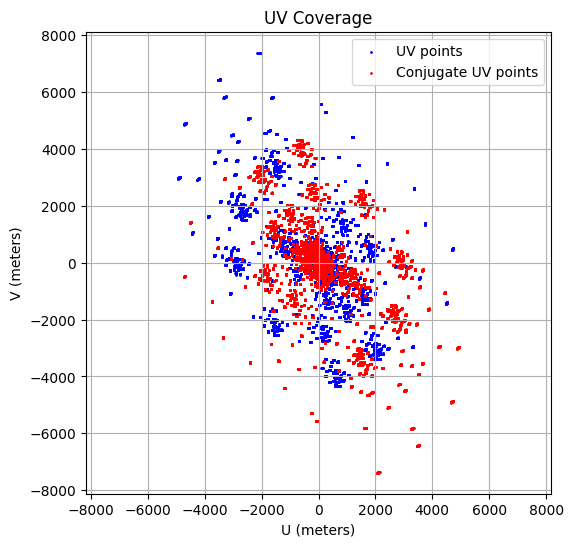

In [ ]:
# Extract UVW coordinates for baselines
uvw_data = ds[0]["UVW"].values

# Separate U, V, and W components
u = uvw_data[:, 0]
v = uvw_data[:, 1]

# Plot the UV coverage
plt.figure(figsize=(6, 6))
plt.scatter(u, v, s=1, color='blue', label='UV points')
plt.scatter(-u, -v, s=1, color='red', label='Conjugate UV points')
plt.xlabel('U (meters)')
plt.ylabel('V (meters)')
plt.title('UV Coverage')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [ ]:
# Compute baseline lengths (Euclidean distance between UVW coordinates)
uvw_lengths = np.sqrt(np.sum(uvw_data ** 2, axis=1))

# Filter out zero-length baselines
non_zero_indices = np.where(uvw_lengths > 0.0)[0]
non_zero_lengths = uvw_lengths[non_zero_indices]

#Find index of shortest non-zero baseline
shortest_non_zero_index = non_zero_indices[np.argmin(non_zero_lengths)]

# Find longest baseline index
longest_index = np.argmax(uvw_lengths)

# Get the antenna names
ant_names = ds[0]["ANTENNA1"].values, ds[0]["ANTENNA2"].values
shortest_pair = (ant_list[ant_names[0][shortest_non_zero_index]],
                 ant_list[ant_names[1][shortest_non_zero_index]])
longest_pair = (ant_list[ant_names[0][longest_index]],
                ant_list[ant_names[1][longest_index]])

print(f"Shortest baseline is between antennas: {shortest_pair}")
print(f"Longest baseline is between antennas: {longest_pair}")
print(f"Shortest baseline length: {uvw_lengths[shortest_non_zero_index]} meters")
print(f"Longest baseline length: {uvw_lengths[longest_index]} meters")


# Get the antenna names
ant_names_1 = ds[0]["ANTENNA1"].values  # Indexes for antenna 1
ant_names_2 = ds[0]["ANTENNA2"].values  # Indexes for antenna 2

# Extract the ANTENNA table
antenna_table = xds_from_table(ms_path + "::ANTENNA")

short_a1 = antenna_table[0]["NAME"].values[0]
short_a2 = antenna_table[0]["NAME"].values[2]

long_a1 = antenna_table[0]["NAME"].values[38]
long_a2 = antenna_table[0]["NAME"].values[47]

#print(antenna_table[0]["NAME"].values[3])


#shortest_pair = (antenna_table[ant_names_1[shortest_non_zero_index]].NAME.data[0],
                # antenna_table[ant_names_2[shortest_non_zero_index]].NAME.data[0])

print(f"Shortest baseline is between antennas: " + str(short_a1) + " and " + str(short_a2))
print(f"Longest baseline is between antennas: " + str(long_a1) + " and " + str(long_a2))

#How to map antenna names from number:
#a1 = 1
#antenna_table[0].NAME.data[a1]



Shortest baseline is between antennas: (0, 2)
Longest baseline is between antennas: (38, 47)
Shortest baseline length: 29.256520999599363 meters
Longest baseline length: 7697.57998251673 meters
m003
Shortest baseline is between antennas: m000 and m002
Longest baseline is between antennas: m048 and m060


In [ ]:
# Constants
c = 3e8  # Speed of light in meters per second
wavelength = 0.21  # Observation wavelength in meters(Assuming HI for Radio Galaxy since PKS is a radio galaxy)

# Calculate baseline lengths for shortest and longest baselines
shortest_baseline = uvw_lengths[shortest_non_zero_index]
longest_baseline = uvw_lengths[longest_index]

# Resolution calculation
resolution_shortest = wavelength / shortest_baseline  # in radians
resolution_longest = wavelength / longest_baseline  # in radians

# Convert resolution from radians to arcseconds
resolution_shortest_arcsec = resolution_shortest * 206265
resolution_longest_arcsec = resolution_longest * 206265

print(f"Resolution on shortest baseline: {resolution_shortest_arcsec:.2f} arcseconds")
print(f"Resolution on longest baseline: {resolution_longest_arcsec:.2f} arcseconds")

# Delay calculation
delay_shortest = shortest_baseline / c  # seconds
delay_longest = longest_baseline / c  # seconds

print(f"Delay on shortest baseline: {delay_shortest:.6e} seconds")
print(f"Delay on longest baseline: {delay_longest:.6e} seconds")


Resolution on shortest baseline: 1480.55 arcseconds
Resolution on longest baseline: 5.63 arcseconds
Delay on shortest baseline: 9.752174e-08 seconds
Delay on longest baseline: 2.565860e-05 seconds


RFI Section

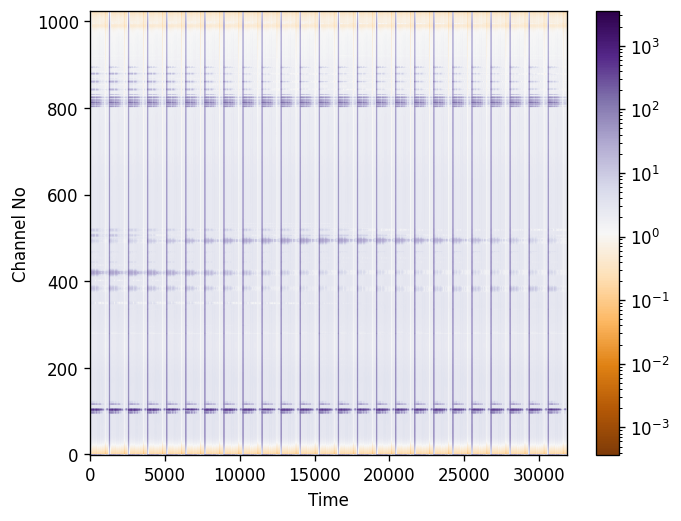

In [ ]:
#A

import matplotlib.colors as colors

vis = ds[0]['DATA']
vis.shape #time, freq, pol

plt.figure(dpi=120)

plt.imshow(np.abs(vis[:,:,0]).T,
           aspect= 'auto',
           origin='lower',
           cmap='PuOr',
           norm = colors.LogNorm()
           );
plt.ylabel('Channel No')
plt.xlabel('Time')
plt.colorbar();
#plt.ylim(800,900)

#this is plotting the wrong thing. what baseline pair should we use
#RFI will be less in long baseline than short baseline

#RFI present at Channel ~101, 813, 500

In [ ]:
from scipy.stats import kurtosis, skew
vis_clean = []
vis_rfi =[]
for a1 in range(0,50): #looking at combined
  for a2 in range(1, 50):
    idx = np.where((ds[0].ANTENNA1==a1)  & (ds[0].ANTENNA2 ==a2))[0] #time:channels:pol

    vis_rfi.append(np.abs(ds[0].DATA.data[idx][:, 410, 0].compute()))
    vis_clean.append(np.abs(ds[0].DATA.data[idx][:, 600, 0].compute()))


combined_array_clean = np.concatenate(vis_clean)
combined_array_rfi = np.concatenate(vis_rfi)

print("Clean_Mean:" + str(np.mean(combined_array_clean)))
print("RFI_Mean:" + str(np.mean(combined_array_rfi)))
print("Clean_Std:" + str(np.std(combined_array_clean)))
print("RFI_Std:" + str(np.std(combined_array_rfi)))

clean_kurtosis = kurtosis(combined_array_clean)
clean_skewness = skew(combined_array_clean)

# Calculate the kurtosis and skewness for RFI regions
rfi_kurtosis = kurtosis(combined_array_rfi)
rfi_skewness = skew(combined_array_rfi)

# Print the results
print("Clean Kurtosis: " + str(clean_kurtosis))
print("RFI Kurtosis: " + str(rfi_kurtosis))
print("Clean Skewness: " + str(clean_skewness))
print("RFI Skewness: " + str(rfi_skewness))

Clean_Mean:4.846796
RFI_Mean:5.3054123
Clean_Std:12.578405
RFI_Std:14.476691
Clean Kurtosis: 27.05218530530113
RFI Kurtosis: 25.97631562329986
Clean Skewness: 5.212556701832473
RFI Skewness: 5.145288935942981


Here we Plot the Histogram for the clean and RFI regions

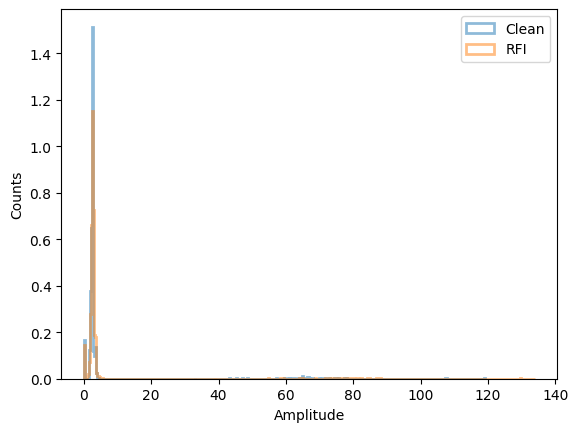

In [ ]:
plt.hist(combined_array_clean,
         bins = 500,
         alpha =0.5,
         histtype = u'step',
         lw = 2,
         density = True,
         label = 'Clean'
         );

plt.hist(combined_array_rfi,
         bins = 500,
         alpha =0.5,
         histtype = u'step',
         lw = 2,
         density = True,
         label = 'RFI'
         );
#plt.xlim(0,10)
plt.xlabel("Amplitude")
plt.ylabel("Counts")
plt.legend()

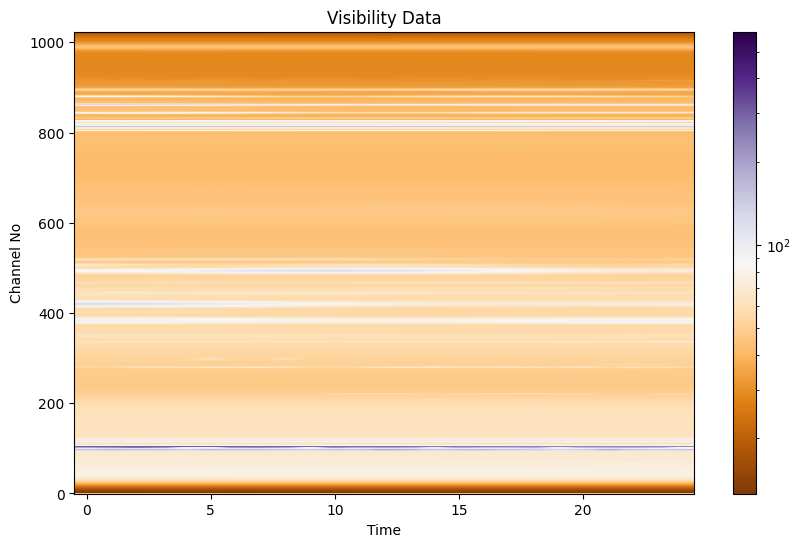

In [ ]:
# Plot the visibility data again for inspection

vis = ds[0].DATA.data[idx]
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(vis[:,:,0]).T,
           aspect= 'auto',
           origin='lower',
           cmap='PuOr',
           norm=colors.LogNorm())
plt.ylabel('Channel No')
plt.xlabel('Time')
plt.colorbar()
plt.title('Visibility Data')
plt.show()


rfi_regions = [
    {'time_range': (200, 300), 'channel_range': (800, 900)},  # Region 1
    {'time_range': (400, 450), 'channel_range': (700, 750)},  # Region 2
    {'time_range': (600, 650), 'channel_range': (600, 650)}   # Region 3
]




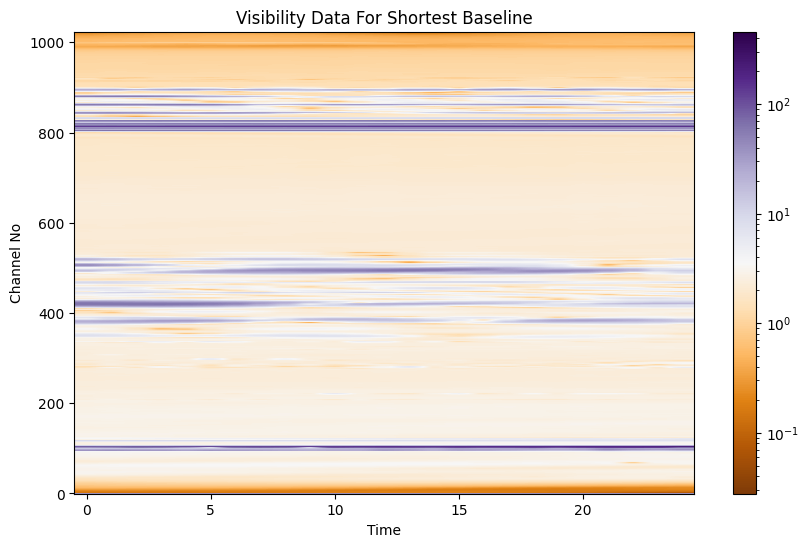

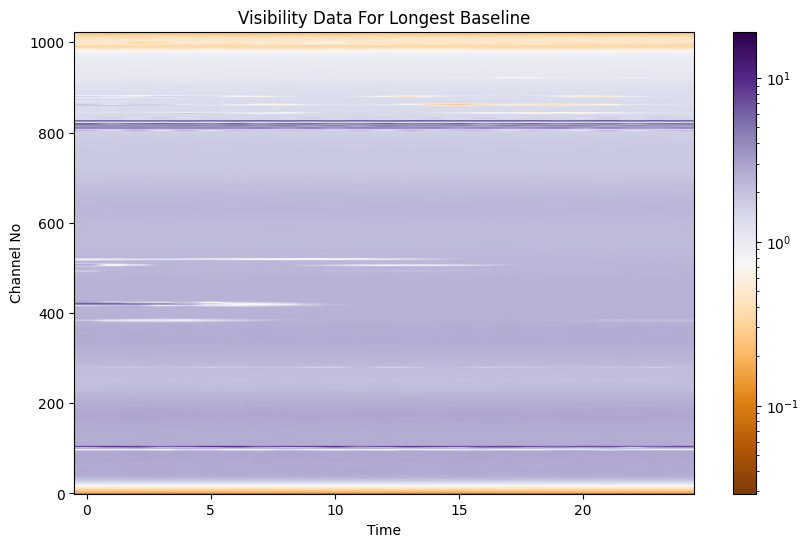

In [ ]:
# Shortest Baseline Visibility
a1 = 0
a2 = 2
short_baseline_idx = np.where((ds[0].ANTENNA1==a1)  & (ds[0].ANTENNA2 ==a2))[0]
short_baseline_vis = np.abs(ds[0].DATA.data[short_baseline_idx])

plt.figure(figsize=(10, 6))
plt.imshow(np.abs(short_baseline_vis[:,:,0]).T,
           aspect= 'auto',
           origin='lower',
           cmap='PuOr',
           norm=colors.LogNorm())
plt.ylabel('Channel No')
plt.xlabel('Time')
plt.colorbar()
plt.title('Visibility Data For Shortest Baseline')
plt.show()

# Longest Baseline Visibility
a1 = 38
a2 = 47
long_baseline_idx = np.where((ds[0].ANTENNA1==a1)  & (ds[0].ANTENNA2 ==a2))[0]
long_baseline_vis = np.abs(ds[0].DATA.data[long_baseline_idx])

plt.figure(figsize=(10, 6))
plt.imshow(np.abs(long_baseline_vis[:,:,0]).T,
           aspect= 'auto',
           origin='lower',
           cmap='PuOr',
           norm=colors.LogNorm())
plt.ylabel('Channel No')
plt.xlabel('Time')
plt.colorbar()
plt.title('Visibility Data For Longest Baseline')
plt.show()




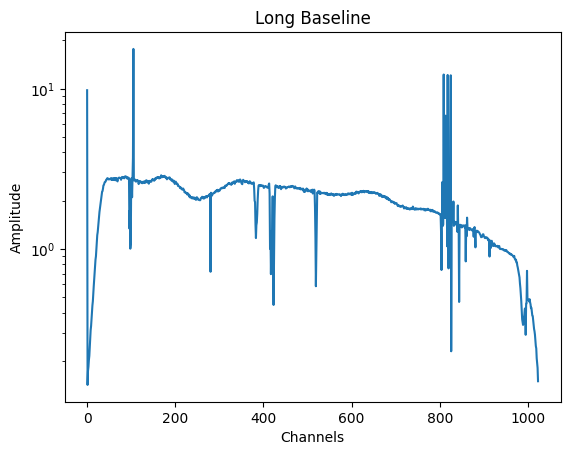

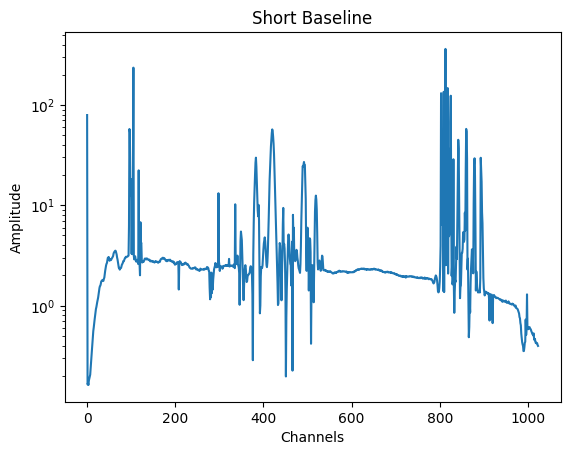

In [ ]:
# Doing a 1-D cut across the visibility
long_baseline_vis = np.abs(ds[0].DATA.data[long_baseline_idx])
plt.plot(np.abs(long_baseline_vis[5,:,0]))
plt.semilogy()
plt.title("Long Baseline")
plt.ylabel('Amplitude')
plt.xlabel('Channels')
plt.show()


short_baseline_vis = np.abs(ds[0].DATA.data[short_baseline_idx])
plt.plot(np.abs(short_baseline_vis[5,:,0]))
plt.semilogy()
plt.title("Short Baseline")
plt.ylabel('Amplitude')
plt.xlabel('Channels')
plt.show()

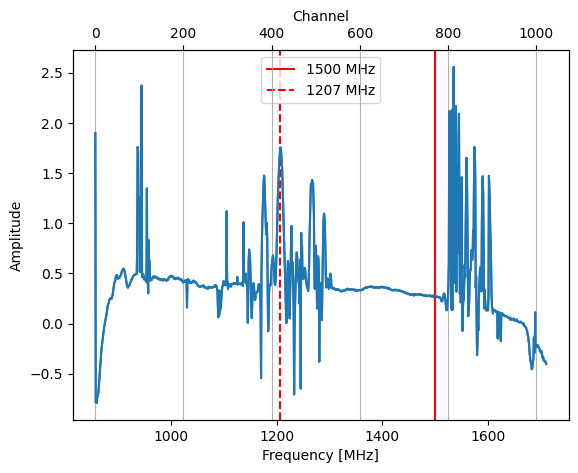

In [ ]:
spectral_table = xds_from_table(ms_path + "::SPECTRAL_WINDOW")
frequencies = spectral_table[0]['CHAN_FREQ'].values.T
absdata = np.abs(vis[5,:,0]).compute()
short_baseline_vis = np.abs(ds[0].DATA.data[short_baseline_idx])
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(frequencies/1.e6,np.log10(short_baseline_vis[5,:,0]),'-')
#ax1.set_xticks(np.arange(frequencies[0]/1.e6,frequencies[-1]/1.e6, step=100))
ax1.axvline(x = 1500, color = 'red', label = "1500 MHz")
ax1.axvline(x = 1207,color = 'red', linestyle = "--", label = "1207 MHz")
ax1.set_xlabel('Frequency [MHz]')
ax1.set_ylabel('Amplitude')
ax1.legend()

ax2.plot(np.log10(short_baseline_vis[5,:,0]))
ax2.set_xlabel('Channel')

plt.grid()

HPBW at 1207 MHz: [10.03125] MHz


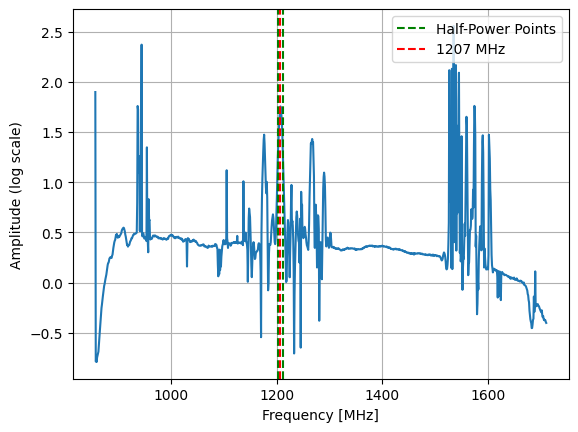

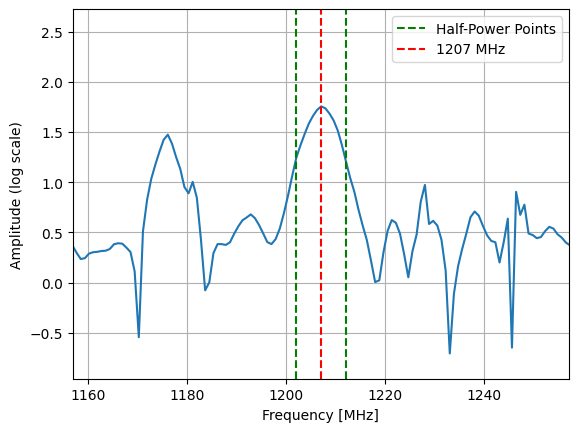

Number of channels impacted by RFI: 13


In [ ]:
import numpy as np
import matplotlib.pyplot as plt



# Find the index of the channel closest to 1207 MHz
target_freq = 1207e6  # 1207 MHz in Hz
idx_1207 = np.argmin(np.abs(frequencies - target_freq))

# Extract the visibility data around 1207 MHz
vis_at_1207 = np.log10(short_baseline_vis[5, :, 0]).compute()

# Find the peak amplitude of the RFI at 1207 MHz
peak_value = vis_at_1207[idx_1207]

# Calculate the half-power value (this is 10^(-0.5) of the peak in log scale)
half_power_value = peak_value - 0.5

# Find the indices where the signal crosses the half-power value
left_idx = np.where(vis_at_1207[:idx_1207] <= half_power_value)[0][-1]
right_idx = np.where(vis_at_1207[idx_1207:] <= half_power_value)[0][0] + idx_1207

# Calculate HPBW in MHz
hpbw_mhz = (frequencies[right_idx] - frequencies[left_idx]) / 1e6

print(f"HPBW at 1207 MHz: {hpbw_mhz} MHz")

# Plotting for visual confirmation
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(frequencies/1.e6, vis_at_1207, '-')
ax1.axvline(x=frequencies[left_idx]/1.e6, color='green', linestyle='--', label='Half-Power Points')
ax1.axvline(x=frequencies[right_idx]/1.e6, color='green', linestyle='--')
ax1.axvline(x=1207, color='red', linestyle='--', label='1207 MHz')
ax1.set_xlabel('Frequency [MHz]')
ax1.set_ylabel('Amplitude (log scale)')
plt.grid()
plt.legend()
plt.show()


fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(frequencies/1.e6, vis_at_1207, '-')
ax1.axvline(x=frequencies[left_idx]/1.e6, color='green', linestyle='--', label='Half-Power Points')
ax1.axvline(x=frequencies[right_idx]/1.e6, color='green', linestyle='--')
ax1.axvline(x=1207, color='red', linestyle='--', label='1207 MHz')
ax1.set_xlabel('Frequency [MHz]')
ax1.set_ylabel('Amplitude (log scale)')

# Zoom in on the frequency range around 1207 MHz
zoom_margin = 50
ax1.set_xlim([1207 - zoom_margin, 1207 + zoom_margin])

plt.grid()
plt.legend()
plt.show()

# Calculate the number of impacted channels
impacted_channels = right_idx - left_idx + 1

print(f"Number of channels impacted by RFI: {impacted_channels}")

In [ ]:

f_obs = 1207e6  # 1207 MHz in Hz
f_em = 1420.40575177e6  # HI rest-frame frequency in Hz

# Calculate redshift
z = (f_em / f_obs) - 1

print(f"The redshift corresponding to 1207 MHz is: {z:.4f}")

The redshift corresponding to 1207 MHz is: 0.1768


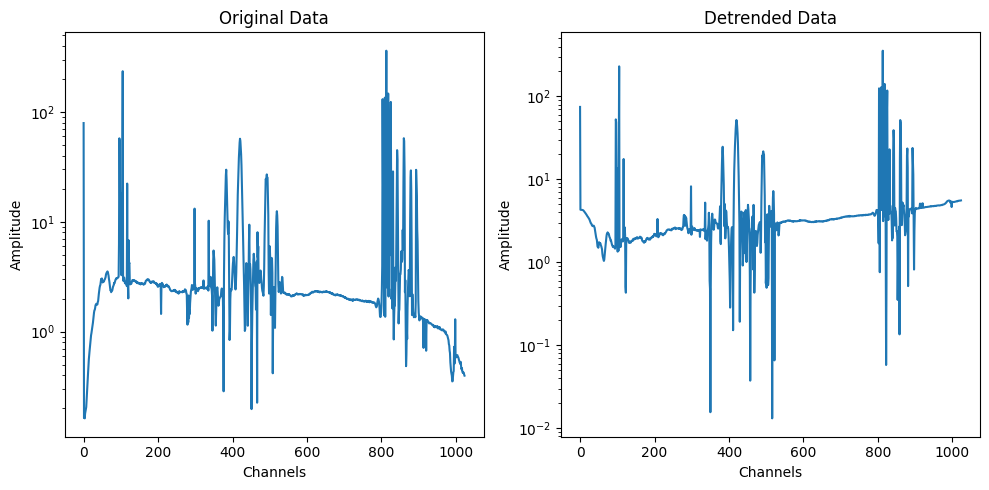

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend

# Extract the short baseline visibility data
short_baseline_vis = np.abs(ds[0].DATA.data[short_baseline_idx])

# Detrend the visibility data for the time slice at index 5
detrended_vis = detrend(short_baseline_vis[5, :, 0])

# Plot the original data and detrended data for comparison
plt.figure(figsize=(10,5))

# Original data
plt.subplot(1, 2, 1)
plt.plot(np.abs(short_baseline_vis[5,:,0]))
plt.semilogy()
plt.title('Original Data')
plt.ylabel('Amplitude')
plt.xlabel('Channels')

# Detrended data
plt.subplot(1, 2, 2)
plt.plot(np.abs(detrended_vis))
plt.semilogy()
plt.title('Detrended Data')
plt.ylabel('Amplitude')
plt.xlabel('Channels')

plt.tight_layout()
plt.show()

Did Detrending work?


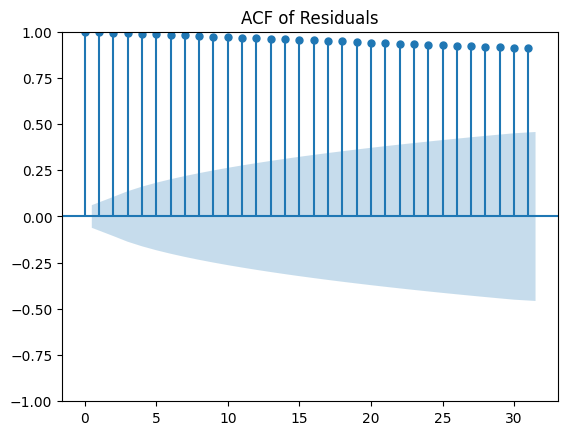

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Plot autocorrelation of the residuals
residuals = short_baseline_vis[5, :, 0] - detrended_vis
plot_acf(residuals)
plt.title("ACF of Residuals")\
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Reshape data for linear regression
X = np.arange(short_baseline_vis[5, :, 0].shape[0]).reshape(-1, 1)
y = short_baseline_vis[5, :, 0]

# Fit linear model to extract the trend
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)

# Calculate R² to see how much of the data was explained by the trend
r2 = r2_score(y, trend)
print(f"R² score of trend: {r2:.3f}")

R² score of trend: 0.001


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on residuals
adf_result = adfuller(residuals)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

# A p-value below a significance level indicates stationarity
if adf_result[1] < 0.05:
    print("Residuals are stationary, detrending is likely good.")
else:
    print("Residuals are not stationary, detrending may need improvement.")

ADF Statistic: -0.0487467391660206
p-value: 0.9543102597076992
Residuals are not stationary, detrending may need improvement.


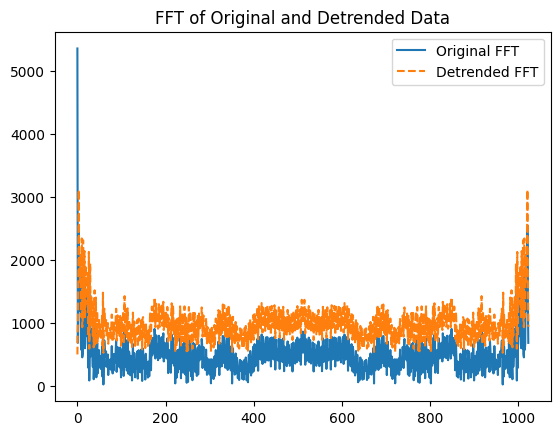

In [ ]:
from scipy.fft import fft

# FFT of the original and detrended data
fft_original = np.abs(fft(np.asarray(short_baseline_vis[5, :, 0]))) # Convert to NumPy array
fft_detrended = np.abs(fft(np.asarray(detrended_vis))) # Convert to NumPy array

# Plot both FFTs for comparison
plt.plot(fft_original, label='Original FFT')
plt.plot(fft_detrended + 500, label='Detrended FFT', linestyle = "--")
plt.legend()
plt.title('FFT of Original and Detrended Data')
plt.show()

Filtering Methods: Threshold based flagging

/usr/local/lib/python3.10/dist-packages/dask/array/core.py:1705: FutureWarning: The `numpy.copy` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


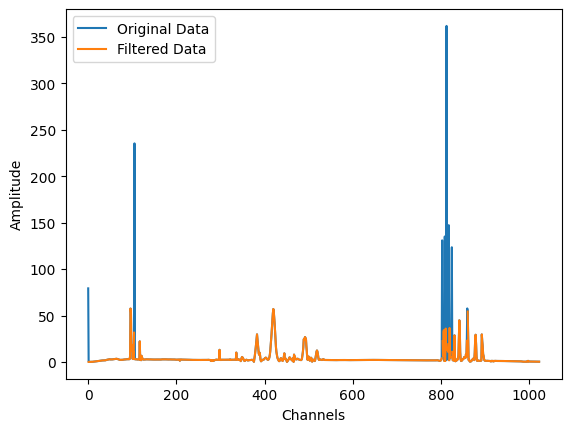

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


amplitude_data = np.abs(short_baseline_vis[5, :, 0])

# Set a threshold
threshold = np.mean(amplitude_data) + 3 * np.std(amplitude_data)

# Flag data points above the threshold as RFI
rfi_mask = amplitude_data > threshold

# Replace RFI points with NaNs or zeros
filtered_data = np.copy(amplitude_data)
filtered_data[rfi_mask] = np.nan

# Plot the original and filtered data
plt.plot(amplitude_data, label='Original Data')
plt.plot(filtered_data, label='Filtered Data')
plt.ylabel('Amplitude')
plt.xlabel('Channels')
plt.legend()
plt.show()

Filter Method: Fourier Transform, cutting off frequencies.

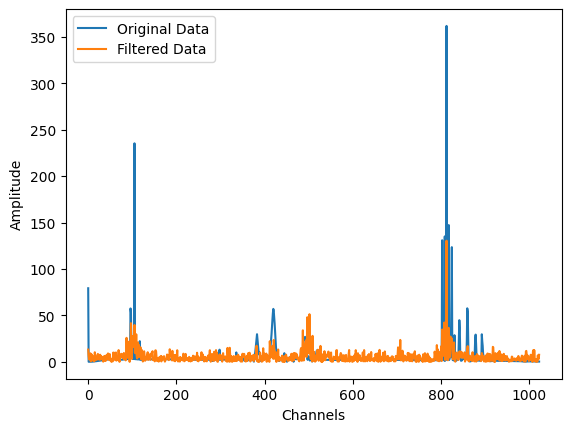

In [ ]:
from scipy.fft import fft, ifft

amplitude_data = np.abs(short_baseline_vis[5, :, 0])
# Perform FFT on the data
fft_data = fft(np.asarray(amplitude_data))


# Zero out frequencies that correspond to RFI
rfi_threshold = np.max(np.abs(fft_data)) * 0.1  # Arbitrary threshold
fft_data[np.abs(fft_data) > rfi_threshold] = 0

# Perform inverse FFT to get the filtered signal back in the time domain
filtered_data = ifft(fft_data)

# Plot the original and filtered data
plt.plot(amplitude_data, label='Original Data')
plt.plot(np.abs(filtered_data), label='Filtered Data')
plt.ylabel('Amplitude')
plt.xlabel('Channels')
plt.legend()
plt.show()

Satelite

Satelite

In [ ]:

ms_dataset = xds_from_ms(ms_path)

# Inspect the dataset for field information (you can list various attributes)
field_data = xds_from_table(ms_path + "::FIELD")
print(field_data)

[<xarray.Dataset> Size: 89B
Dimensions:        (row: 1, field-poly: 1, field-dir: 2)
Coordinates:
    ROWID          (row) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: row, field-poly, field-dir
Data variables:
    FLAG_ROW       (row) bool 1B dask.array<chunksize=(1,), meta=np.ndarray>
    CODE           (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    NAME           (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    TIME           (row) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    PHASE_DIR      (row, field-poly, field-dir) float64 16B dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    NUM_POLY       (row) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    SOURCE_ID      (row) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    REFERENCE_DIR  (row, field-poly, field-dir) float64 16B dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    DELAY_DIR      (row, field-poly, field-dir) float64 16B 

In [ ]:
ra_pks =field_data[0]["PHASE_DIR"].data[0, 0].compute()[0]  # Extract RA
dec_pks = field_data[0].PHASE_DIR.data[0, 0].compute()[1]  # Extract Dec

ra_deg = np.degrees(5.146178203219011)
dec_deg = np.degrees(-1.111996293372655)

print(f"PKS1934-63 RA (degrees): {ra_deg}")
print(f"PKS1934-63 Dec (degrees): {dec_deg}")

PKS1934-63 RA (degrees): 294.85429166666665
PKS1934-63 Dec (degrees): -63.71269444444445


In [ ]:
!pip install skyfield

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.2/336.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 20.7 MB/s eta 0:00:00


In [ ]:
from skyfield.api import load, EarthSatellite, Topos

# Load TLE data from the txt file
tle_file = data_path + "requested_TLE.txt"

# Function to parse TLE file
def load_tle_from_txt(filename):
    satellites = []
    with open(filename) as f:
        lines = f.readlines()
        for i in range(0, len(lines), 3):  # Each satellite has 3 lines: name, line1, and line2
            name = lines[i].strip()
            line1 = lines[i+1].strip()
            line2 = lines[i+2].strip()
            satellite = EarthSatellite(line1, line2, name)
            satellites.append(satellite)
    return satellites

# Load the satellites from the TLE file
satellites = load_tle_from_txt(tle_file)

# Set the observation location (MeerKAT)
observing_location = Topos(latitude_degrees=-30.684007, longitude_degrees=21.491191)

# Set the observation time
ts = load.timescale()
t = ts.utc(2019, 1, 30, 12, 0, 0)

for satellite in satellites:
    # Get the position of the satellite at the specified time
    subpoint = satellite.at(t).subpoint()

    # Extract latitude, longitude, and altitude of the satellite's subpoint
    latitude = subpoint.latitude.degrees
    longitude = subpoint.longitude.degrees
    altitude = subpoint.elevation.km

    # Print satellite's name, latitude, longitude, and altitude
    print(f'Satellite: {satellite.name}, Latitude: {latitude}, Longitude: {longitude}, Altitude: {altitude} km')


Satellite: BEIDOU-2 IGSO-7, Latitude: -42.806433367697586, Longitude: 97.81632619532495, Altitude: 35752.72422925631 km
Satellite: BEIDOU-2 IGSO-7, Latitude: -42.80590291587574, Longitude: 97.81532854714952, Altitude: 35752.81432796653 km
Satellite: BEIDOU-2 IGSO-7, Latitude: -42.80555890674275, Longitude: 97.81456010826628, Altitude: 35752.87151003668 km
Satellite: BEIDOU-2 IGSO-7, Latitude: -42.805300892578146, Longitude: 97.81403117425084, Altitude: 35752.8895216318 km
Satellite: BEIDOU-3 M2, Latitude: -54.47017873913226, Longitude: 101.1011198429573, Altitude: 21533.68856832198 km
Satellite: BEIDOU-3 M2, Latitude: -54.470139193963306, Longitude: 101.10073294934037, Altitude: 21533.609392038536 km
Satellite: BEIDOU-3 M2, Latitude: -54.4701472907179, Longitude: 101.10057133464622, Altitude: 21533.60771283917 km
Satellite: BEIDOU-3 M2, Latitude: -54.46989222008558, Longitude: 101.10007835061323, Altitude: 21533.580377189006 km
Satellite: BEIDOU-3 M2, Latitude: -54.47011040584229, Long

In [ ]:
import math
from skyfield.api import load, EarthSatellite, Topos

# Load TLE data from the txt file
tle_file = data_path + "requested_TLE.txt"

# Function to parse TLE file
def load_tle_from_txt(filename):
    satellites = []
    with open(filename) as f:
        lines = f.readlines()
        for i in range(0, len(lines), 3):  # Each satellite has 3 lines: name, line1, and line2
            name = lines[i].strip()
            line1 = lines[i+1].strip()
            line2 = lines[i+2].strip()
            satellite = EarthSatellite(line1, line2, name)
            satellites.append(satellite)
    return satellites

# Load the satellites from the TLE file
satellites = load_tle_from_txt(tle_file)

# Set the observation time
ts = load.timescale()
t = ts.utc(2019, 1, 30, 12, 56, 12)

# PKS1934-63 coordinates (RA/Dec)
pks_ra = (19 + 39/60 + 25/3600) * 15  # Convert RA to degrees
pks_dec = - (63 + 42/60 + 45.63/3600)  # Convert Dec to degrees

# Set to keep track of unique satellite names
unique_satellite_names = set()

# Loop through satellites and calculate angular separation
for satellite in satellites:
    # Get the satellite's geocentric position at the specified time
    geocentric = satellite.at(t)

    # Get the satellite's position in the equatorial coordinate system
    x, y, z = geocentric.position.au  # Position in astronomical units

    # Convert to RA and Dec
    if x != 0 or y != 0:  # Avoid division by zero
        satellite_ra = math.atan2(y, x) * (180 / math.pi)  # RA in degrees
    else:
        satellite_ra = 0  # Default to 0 if x and y are both zero

    satellite_dec = math.atan2(z, math.sqrt(x**2 + y**2)) * (180 / math.pi)  # Dec in degrees

    # Convert RA from degrees to radians for calculation
    ra1_rad = math.radians(pks_ra)
    dec1_rad = math.radians(pks_dec)
    ra2_rad = math.radians(satellite_ra)
    dec2_rad = math.radians(satellite_dec)

    # Calculate angular separation
    separation = math.acos(
        math.sin(dec1_rad) * math.sin(dec2_rad) +
        math.cos(dec1_rad) * math.cos(dec2_rad) * math.cos(ra1_rad - ra2_rad)
    ) * (180 / math.pi)  # Convert to degrees

    # Check if the satellite name is already recorded
    if satellite.name not in unique_satellite_names:
        # Print the angular separation only for the first instance
        print(f'Angular separation from PKS1934-63 to {satellite.name}: {separation} degrees')
        unique_satellite_names.add(satellite.name)  # Add to the set




Angular separation from PKS1934-63 to BEIDOU-2 IGSO-7: 59.26237564700373 degrees
Angular separation from PKS1934-63 to BEIDOU-3 M2: 64.23807539184769 degrees
Angular separation from PKS1934-63 to GSAT0221 (GALILEO 25): 108.23657614665281 degrees
Angular separation from PKS1934-63 to BEIDOU-3 M9: 97.58674723482002 degrees
Angular separation from PKS1934-63 to GSAT0204 (GALILEO 8): 64.72375147389255 degrees
Angular separation from PKS1934-63 to BEIDOU-2 IGSO-5: 149.81871069292407 degrees
Angular separation from PKS1934-63 to BEIDOU-2 G5: 87.45834602310163 degrees
Angular separation from PKS1934-63 to GSAT0201 (GALILEO 5): 166.4639674932136 degrees
Angular separation from PKS1934-63 to BEIDOU-2 M6: 113.79129484006943 degrees
Angular separation from PKS1934-63 to BEIDOU-3 M4: 58.580839095671244 degrees
Angular separation from PKS1934-63 to COSMOS 2485 [GLONASS-M]: 132.10370085176913 degrees
Angular separation from PKS1934-63 to BEIDOU-3S M2S: 84.21097383057366 degrees
Angular separation fr